# Introdução

Esse trabalho tem como interesse comparar os resultados de modelos e mostrar a validade do método de Transfer Learning em tarefas de classificação. Temos como alvo a classificação de imagens de capivaras e equino.

O primeiro modelo utiliza transfer learning com pesos treinados no Xception para as primeiras camadas, seguido por um MLP com saida softmax para a classificação. O segundo modelo utiliza a mesma arquitetura do primeiro, porém sem os pesos pré-treinados. O terceiro modelo é apenas um MLP treinado do zero.

Foram utilizadas 1004 imagens para treinamento e 249 para validação, coloridas e com dimensão 224x224. Além disso, foi utilizado um processo de data augmentation para rotação das imagens. Os modelos foram treinado para 25 épocas e com tamanho de batch 64.

# Resultados

Como era esperado, o modelo primeiro modelo apresentou resultados significativamente superiores, justificando a utilização do transfer leaning. Foi observado 90% de acurácia de validação e valores acima 80% para precisão e recall.

O segundo modelo apresentou acurácia de apenas 52%. Essa métrica se mantem constante durante todo o treinamento e a perda não melhora com o passar das épocas. É interessante notar também que o modelo só foi capaz de detectar uma das classes durante o treinamento. Talvez fosse necessária uma base de dados maior e mais tempo de treinamento para que esse tipo de modelo fosse capaz de obter bons resultados.

O terceiro modelo foi o pior dos três com apenas 40% de acurácia. Apesar de ser inferior ao segundo modelo, foi capaz de detectar as duas classes para o mesmo conjunto de imagens e período de treinamento, ainda que sem grandes resultados.

# Pacotes

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras
import sklearn
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os
from os import listdir
from os.path import isfile, join
import re

# Primeiro Modelo

## Xception

In [2]:
img_rows, img_cols = 224, 224 
    
# Re-loads the MobileNet model without the top or FC layers
xception = keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in xception.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(xception.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 SeparableConv2D False
8 BatchNormalization False
9 Activation False
10 SeparableConv2D False
11 BatchNormalization False
12 Conv2D False
13 MaxPooling2D False
14 BatchNormalization False
15 Add False
16 Activation False
17 SeparableConv2D False
18 BatchNormalization False
19 Activation False
20 SeparableConv2D False
21 BatchNormalization False
22 Conv2D False
23 MaxPooling2D False
24 BatchNormalization False
25 Add False
26 Activation False
27 SeparableConv2D False
28 BatchNormalization False
29 Activation False
30 SeparableConv2D False
31 BatchNormalization False
32 Conv2D False
33 MaxPooling2D False
34 BatchNormalization False
35 Add False
36 Activation False
37 SeparableConv2D False
38 BatchNormalization False
39 Activation False
40 SeparableConv2D False
41 BatchNormalization False
42 Activation False
43 SeparableConv2D False
44 BatchNormaliz

## Criando modelo do topo

In [3]:
def addTopModelXception(bottom_model):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(2, activation='softmax')(top_model)
    return top_model

## Juntando o modelo base com o topo

In [4]:
FC_Head = addTopModelXception(xception)
model = Model(inputs = xception.input, outputs = FC_Head)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

## Instantiate ImageDataGenerators for augmenting the data

In [5]:
train_data_dir = 'training/'
validation_data_dir = 'validation/'

train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255.)

## Data augmentation para classificação

In [6]:
batch_size = 64
 
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,
                                                    class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=batch_size, class_mode='categorical')

Found 1004 images belonging to 2 classes.
Found 249 images belonging to 2 classes.


## Criando callbacks para o modelo de classificação

In [7]:
checkpoint = ModelCheckpoint("trained_model/animals_xception_adam1.h5", monitor="val_loss", mode="min", 
                             save_best_only = True, verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [checkpoint, reduce_lr] #[earlystop, checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

## Declarando constantes

In [8]:
nb_train_samples = 1004
nb_validation_samples = 249

epochs = 25
batch_size = 64

## Treinando o modelo para classificação de animais

In [9]:
history = model.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.8223
Epoch 1: val_loss improved from inf to 0.20348, saving model to trained_model\animals_xception_adam1.h5
15/15 [==============================] - 128s 8s/step - loss: 0.5288 - accuracy: 0.8223 - val_loss: 0.2035 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9660
Epoch 2: val_loss improved from 0.20348 to 0.20218, saving model to trained_model\animals_xception_adam1.h5
15/15 [==============================] - 136s 9s/step - loss: 0.1132 - accuracy: 0.9660 - val_loss: 0.2022 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9691
Epoch 3: val_loss did not improve from 0.20218
15/15 [==============================] - 153s 10s/step - loss: 0.0796 - accuracy: 0.9691 - val_loss: 0.2220 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 4/25
15/15 [===========

## Avaliando

In [15]:
def plotLearningCurves(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.epoch, history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('accuracy vs epoch')

In [31]:
np.save('history.npy',history.history)

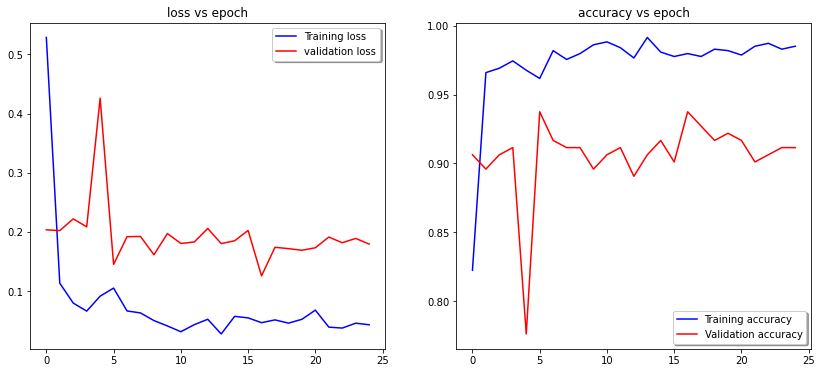

In [11]:
plotLearningCurves(history) 

In [12]:
m1 = keras.models.load_model('trained_model/animals_xception_adam1.h5')

### Imagens preditas

In [13]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(classes)

['n0', 'n1']


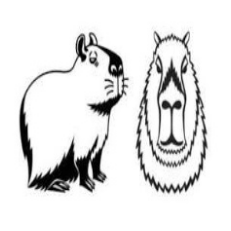

Predicted:  n1
True:  n1

---------------------------------------------------


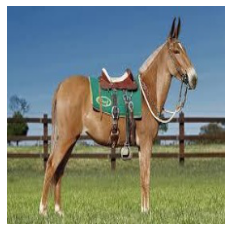

Predicted:  n0
True:  n0

---------------------------------------------------


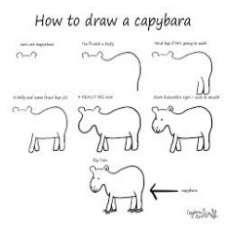

Predicted:  n1
True:  n1

---------------------------------------------------


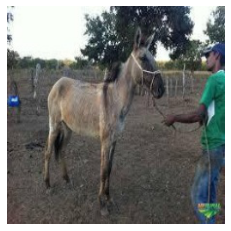

Predicted:  n0
True:  n0

---------------------------------------------------


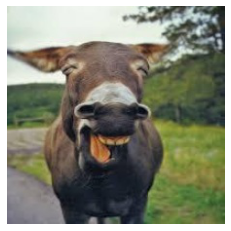

Predicted:  n0
True:  n0

---------------------------------------------------


In [14]:
# checking model on validation data
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 5):
    path = 'validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m1.predict(images, batch_size = 10))
    predictions.append(classes)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted: ",class_labels[predictions[i]])
    print("True: ",true_labels[i])
    print("\n---------------------------------------------------")

### Matrix de confusão

In [15]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m1.predict(images, batch_size = 10))
    predictions.append(classes)

In [16]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [17]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.83      1.00      0.90       114
           1       1.00      0.82      0.90       135

    accuracy                           0.90       249
   macro avg       0.91      0.91      0.90       249
weighted avg       0.92      0.90      0.90       249

validation accuracy: 0.9036144578313253


# Segundo Modelo

## Xception sem os pesos do imagenet

In [18]:
img_rows, img_cols = 224, 224 
    
# Sem os pesos do imagenet (random initialization)
xception_2 = keras.applications.Xception(weights = None, include_top = False, input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in xception_2.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(xception_2.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 SeparableConv2D False
8 BatchNormalization False
9 Activation False
10 SeparableConv2D False
11 BatchNormalization False
12 Conv2D False
13 MaxPooling2D False
14 BatchNormalization False
15 Add False
16 Activation False
17 SeparableConv2D False
18 BatchNormalization False
19 Activation False
20 SeparableConv2D False
21 BatchNormalization False
22 Conv2D False
23 MaxPooling2D False
24 BatchNormalization False
25 Add False
26 Activation False
27 SeparableConv2D False
28 BatchNormalization False
29 Activation False
30 SeparableConv2D False
31 BatchNormalization False
32 Conv2D False
33 MaxPooling2D False
34 BatchNormalization False
35 Add False
36 Activation False
37 SeparableConv2D False
38 BatchNormalization False
39 Activation False
40 SeparableConv2D False
41 BatchNormalization False
42 Activation False
43 SeparableConv2D False
44 BatchNormaliz

## Juntando o modelo base com o topo

In [19]:
FC_Head_2 = addTopModelXception(xception_2)
model_2 = Model(inputs = xception_2.input, outputs = FC_Head_2)
print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [20]:
train_data_dir = 'training/'
validation_data_dir = 'validation/'

train_datagen = ImageDataGenerator(rescale=1./255.0, rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255.0)

In [21]:
checkpoint = ModelCheckpoint("trained_model/animals_xception_adam1_no_weight.h5", monitor="val_loss", mode="min", 
                             save_best_only = True, verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [checkpoint, reduce_lr] #[earlystop, checkpoint, reduce_lr] 

model_2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

## Treinando o modelo

In [22]:
history_2 = model_2.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69292, saving model to trained_model\animals_xception_adam1_no_weight.h5
15/15 [==============================] - 155s 10s/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5365 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5064
Epoch 2: val_loss improved from 0.69292 to 0.68933, saving model to trained_model\animals_xception_adam1_no_weight.h5
15/15 [==============================] - 161s 11s/step - loss: 0.6933 - accuracy: 0.5064 - val_loss: 0.6893 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5032
Epoch 3: val_loss did not improve from 0.68933
15/15 [==============================] - 156s 10s/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6914 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4

In [23]:
model_2.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/Trabalho final/xception_no_imagenet.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
np.save('history_2.npy',history_2.history)

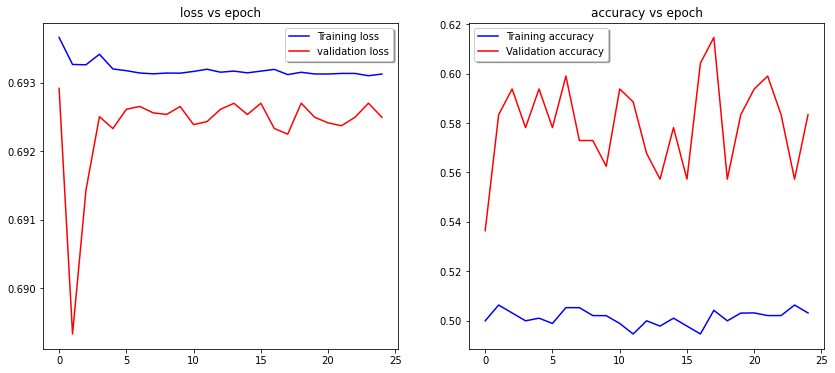

In [24]:
plotLearningCurves(history_2)

## Matriz de confusão

In [32]:
m2 = keras.models.load_model('trained_model/xception_no_imagenet.h5')

In [33]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m2.predict(images, batch_size = 10))
    predictions.append(classes)

In [34]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [35]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.52      1.00      0.69       130

    accuracy                           0.52       249
   macro avg       0.26      0.50      0.34       249
weighted avg       0.27      0.52      0.36       249

validation accuracy: 0.5220883534136547


C:\Users\malta\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Terceiro Modelo

In [9]:
inputs = keras.Input(shape=(img_rows, img_cols, 3))

model_no_transfer = GlobalAveragePooling2D()(inputs)
model_no_transfer = Dense(1024,activation='relu')(model_no_transfer)
model_no_transfer = Dense(1024,activation='relu')(model_no_transfer)
model_no_transfer = Dense(512,activation='relu')(model_no_transfer)
outputs = Dense(2, activation='softmax')(model_no_transfer)

model_no_transfer_2 = keras.Model(inputs, outputs)

model_no_transfer_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 global_average_pooling2d_1   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              4096      
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                           

In [10]:
model_no_transfer_2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [11]:
history_3 = model_no_transfer_2.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.4979
Epoch 1: val_loss improved from inf to 0.75930, saving model to trained_model\animals_xception_adam1.h5
15/15 [==============================] - 39s 2s/step - loss: 0.6963 - accuracy: 0.4979 - val_loss: 0.7593 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5266
Epoch 2: val_loss improved from 0.75930 to 0.70534, saving model to trained_model\animals_xception_adam1.h5
15/15 [==============================] - 13s 859ms/step - loss: 0.6904 - accuracy: 0.5266 - val_loss: 0.7053 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5585
Epoch 3: val_loss did not improve from 0.70534
15/15 [==============================] - 13s 892ms/step - loss: 0.6836 - accuracy: 0.5585 - val_loss: 0.7729 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 4/25
15/15 [=========

In [12]:
model_no_transfer_2.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/Trabalho final/trained_model/xception_no_transfer.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
np.save('history_3.npy',history_3.history)

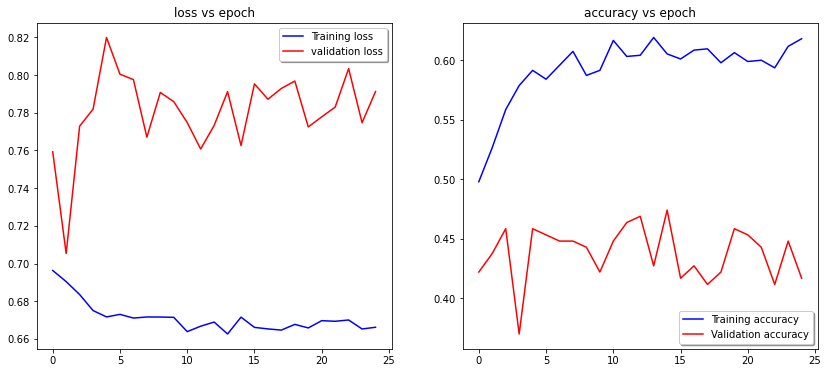

In [16]:
plotLearningCurves(history_3)

## Matriz de confusão

In [17]:
m3 = keras.models.load_model('trained_model/xception_no_transfer.h5')

In [20]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m3.predict(images, batch_size = 10))
    predictions.append(classes)

In [21]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [22]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.47      0.46      0.46       140
           1       0.33      0.34      0.33       109

    accuracy                           0.41       249
   macro avg       0.40      0.40      0.40       249
weighted avg       0.41      0.41      0.41       249

validation accuracy: 0.40562248995983935
